In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import sys
if '..' not in sys.path:
    sys.path.append('..')


import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import matplotlib
import re
# import multiprocessing

# from lib.mobilitysim import MobilitySimulator
from lib.dynamics import DiseaseModel
from lib.distributions import CovidDistributions
from lib.plot import Plotter
from lib.data import collect_data_from_df
from lib.measures import (
    MeasureList, 
    BetaMultiplierMeasure, 
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure, 
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure, 
    ComplianceForAllMeasure,
    Interval)
from lib.runutils import *
from IPython.display import display, HTML

# from lib.mobilitysim import MobilitySimulator
# from lib.town_data import generate_population, generate_sites, compute_distances
# from lib.town_maps import MapIllustrator

## Zihan

In [ ]:
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
import matplotlib.pyplot as plt
rpts = 20
p_compliance = [0.0, 1.0]
measures_deployed = [1,3,6,7]
summaries_SD_6 = load_summary('tracing_isolate_sf_tc1x_sup20_laura_isohouse_20rpts2.pk')
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    f,axs = plt.subplots(2,2,figsize = (13,13))
    num_expo_house = []
    num_expo_contact = []
    for s, summary in enumerate(summaries_):
        multi_3 = 0
        counts = np.zeros((10,))
        num_contacts = 0
        num_nega = np.sum(summary.state['nega'])
        num_posi = np.sum(summary.state['posi'])
        num_expo_house.append(summary.num_expo_house)
        num_expo_contact.append(summary.num_expo_contact)
        num_i_contained_infectious_true = 0
        num_j_contained_infectious_true = 0
        num_i_contained_infectious_false = 0
        num_j_contained_infectious_false = 0
        #axs[1,s].boxplot(summary.state_started_at['posi'][np.multiply(summary.state_started_at['posi']!=np.inf, summary.state_started_at['posi']!=-1)])
        for r in range(rpts):
            num_contacts += len(summary.mob[r])
            for contact in summary.mob[r]:
                if contact.data['i_contained_infectious']==True:
                    num_i_contained_infectious_true += 1
#                 if contact.data['j_contained_infectious']==True:
#                     num_j_contained_infectious_true += 1
                if contact.data['i_contained_infectious']==False:
                    num_i_contained_infectious_false += 1
#                 if contact.data['j_contained_infectious']==False:
#                     num_j_contained_infectious_false += 1
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
#                     if (3 in contact.data['i_contained_by']) or (3 in contact.data['j_contained_by']):
#                         if len()
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        counts /= num_contacts
        axs[0,s].bar(range(1,len(measures_deployed)+1),counts[measures_deployed])
        axs[0,s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[0,s].set_xlabel('contact status',fontsize = 20)
        axs[0,s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[0,s].set_xticks(range(1,len(measures_deployed)+1))
        axs[0,s].set_xticklabels(measures_deployed)
        axs[0,s].set_ylim(0,0.5)
        
        
        print('number of contacts:', num_contacts/rpts)
        print('Tracking compliance '+str(p_compliance[s])+', positive ', num_posi)
        print('Tracking compliance '+str(p_compliance[s])+', negative rate: ', num_nega/(num_nega+num_posi))
        print('i_contained_infectious true rate: ',num_i_contained_infectious_true/(num_i_contained_infectious_true+num_i_contained_infectious_false))
        #print('j_contained_infectious true rate: ',num_j_contained_infectious_true/(num_j_contained_infectious_true+num_j_contained_infectious_false))
    axs[1,0].boxplot(num_expo_house)
    axs[1,0].set_title('Household Exposures')
    axs[1,0].set_xlabel('compliance',fontsize = 20)
    axs[1,0].set_xticklabels(p_compliance)
    axs[1,0].set_ylabel('number of exposures',fontsize = 20)
    axs[1,1].boxplot(num_expo_contact)
    axs[1,1].set_title('Contact Exposures')
    axs[1,1].set_xlabel('compliance',fontsize = 20)
    axs[1,1].set_xticklabels(p_compliance)
    axs[1,1].set_ylabel('number of exposures',fontsize = 20)
#plt.tight_layout()
plt.savefig('plots/tracing_isolate_sf_tc1x_sup20_laura_isohouse_20rpts2_detail.png',dpi=300)
plt.show()

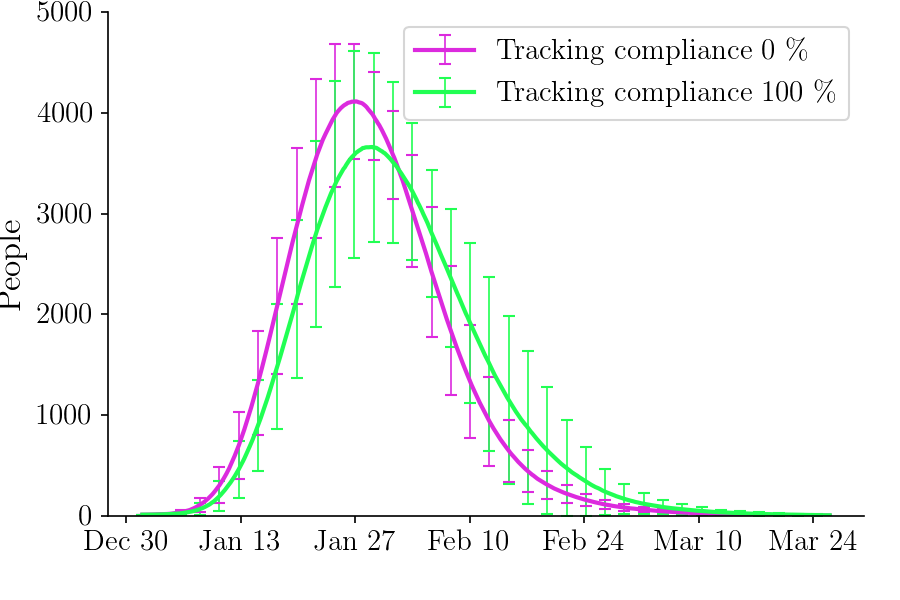

In [27]:
# Plot results of experiments_server_7-1.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('tracing_isolate_sf_tc1x_sup20_laura_isohouse_20rpts2.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}'+'tracing_isolate_sf_tc1x_sup20_laura_isohouse_20rpts2', 
        figsize=FIGSIZE, acc=500, 
        ymax=5000, errorevery=14)

## Laura
### Experiments_server_7-1 with essential workers

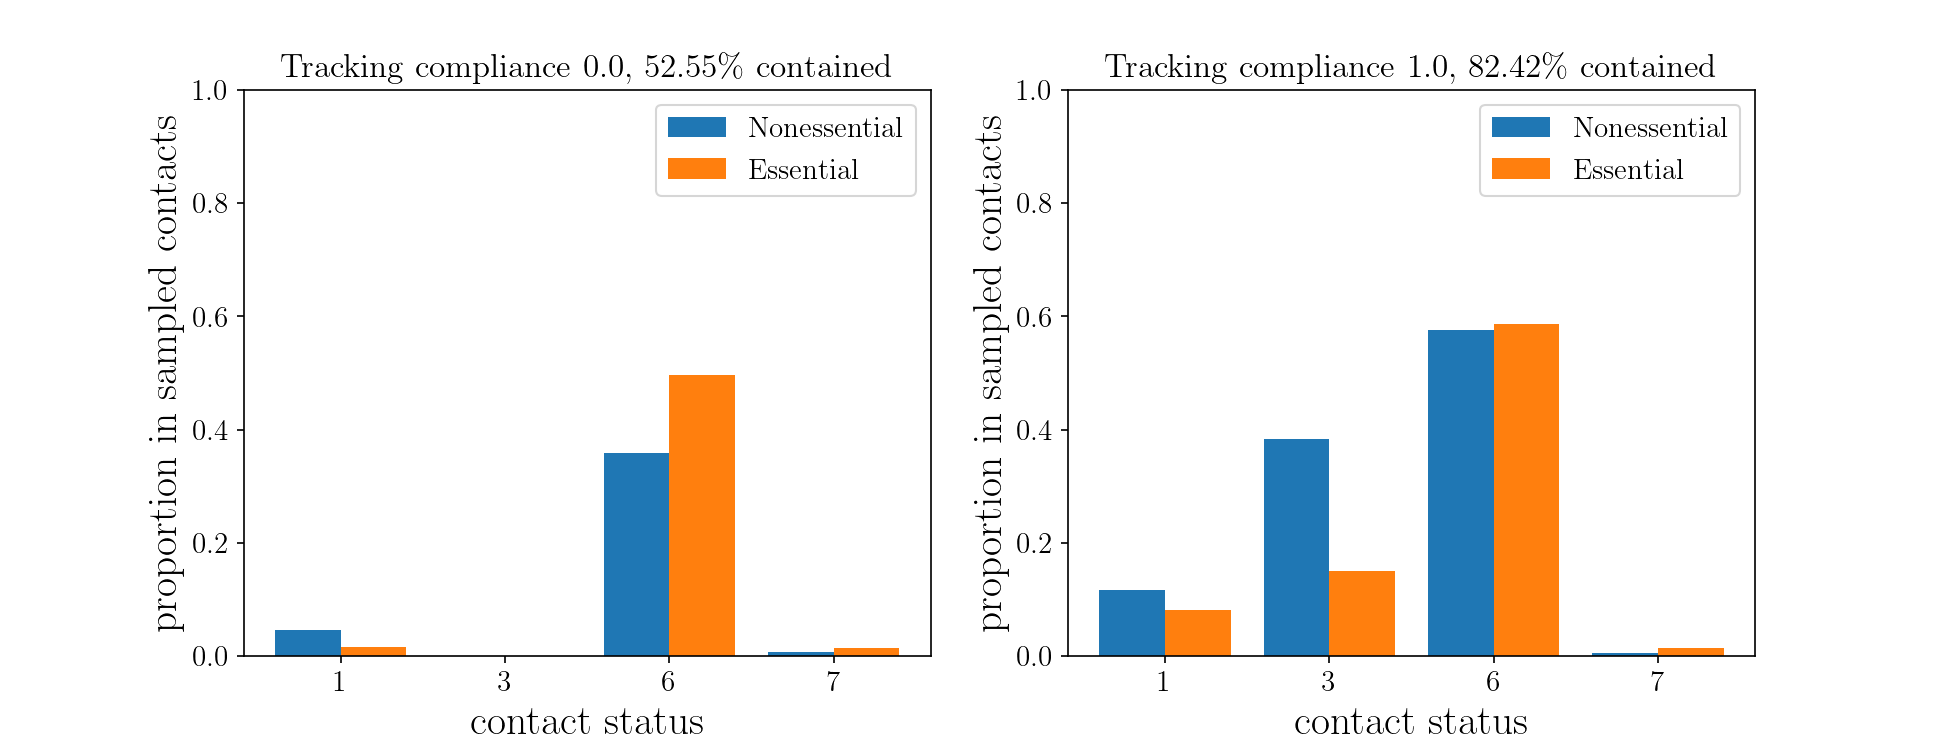

In [3]:
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
import matplotlib.pyplot as plt
p_compliance = [0.0, 1.0]
measures_deployed = [1,3,6,7]
summaries_SD_6 = load_summary('summaries_contacts_supermarket_bh0.pk')
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    f,axs = plt.subplots(1,2,figsize = (13,5))
    for s, summary in enumerate(summaries_):
        essential_counts = np.zeros((10,))
        essential_num_contacts = 0
        nonessential_counts = np.zeros((10,))
        nonessential_num_contacts = 0
        for r in range(summary.random_repeats):
            for contact in summary.mob[r]:
                if (summary.essential_workers[0][contact.indiv_j]==True):
                    essential_num_contacts += 1
                    counts = essential_counts
                else:
                    nonessential_num_contacts += 1
                    counts = nonessential_counts
                    
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        
        essential_counts /= essential_num_contacts
        nonessential_counts /= nonessential_num_contacts
        width = 0.4
        xticks = np.arange(1,len(measures_deployed)+1)
        axs[s].bar(xticks-0.2,nonessential_counts[measures_deployed],width=width, label='Nonessential')
        axs[s].bar(xticks+0.2,essential_counts[measures_deployed],width=width, label='Essential')
        axs[s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[s].set_xlabel('contact status',fontsize = 20)
        axs[s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[s].set_xticks(range(1,len(measures_deployed)+1))
        axs[s].set_xticklabels(measures_deployed)
        axs[s].set_ylim(0,1.0)
        axs[s].legend()
#plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()

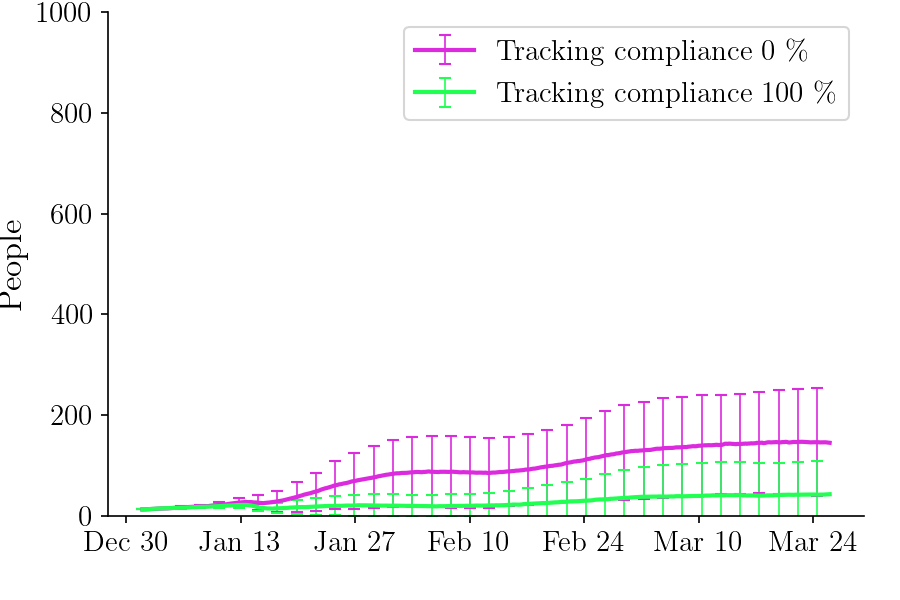

In [4]:
# Graph num infected
c=0
runstr = f'run{c}_'
# summaries_SD_6 = load_summary('contact_record_test_1.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = Plotter()
titles_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_list = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_list, 
        titles=titles_, 
        filename=runstr + f'experiments_7-1', 
        figsize=FIGSIZE, acc=500, 
        ymax=1000, errorevery=14)

In [5]:
for summ in summaries_SD_6['advanced']:
    df = make_summary_df(summ)
    display(df)

,Total,Nonessential,Essential
num_people,4254,2121,2133
num_infected,882.3,533.025,349.275
pct_infected,20.7%,25.1%,16.4%
num_contacts,678.3,462.25,216.05


,Total,Nonessential,Essential
num_people,4254,2121,2133
num_infected,401.05,240.75,160.3
pct_infected,9.4%,11.4%,7.5%
num_contacts,197.1,149.7,47.4


### Experiments_essential.py

In [ ]:
# Plot results of experiments_essential.py
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
measures = np.array(['SDForAll', 'SDForPositive', 'SDByAge', 'SDForSmartTracing','SDForKGroups','UpperBound','resi/dead','hosp','site_measures','not contained'])

import matplotlib.pyplot as plt
p_compliance = [0.0, 0.5]
measures_deployed = [1,3,6,7]
summaries_ = load_summary('summaries_r45.pk')

f,axs = plt.subplots(2,2,figsize = (13,10))
for j, policy in enumerate(['random','essential']):
    for s in range(len(p_compliance)):
        summary = summaries_[(policy,p_compliance[s])]
        essential_counts = np.zeros((10,))
        essential_num_contacts = 0
        nonessential_counts = np.zeros((10,))
        nonessential_num_contacts = 0
        for r in range(summary.random_repeats):
            for contact in summary.mob[r]:
                if (summary.essential_workers[0][contact.indiv_j]==True):
                    essential_num_contacts += 1
                    counts = essential_counts
                else:
                    nonessential_num_contacts += 1
                    counts = nonessential_counts
                    
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
        
        essential_counts /= essential_num_contacts
        nonessential_counts /= nonessential_num_contacts
        width = 0.4
        xticks = np.arange(1,len(measures_deployed)+1)
        axs[j,s].bar(xticks-0.2,nonessential_counts[measures_deployed],width=width, label='Nonessential')
        axs[j,s].bar(xticks+0.2,essential_counts[measures_deployed],width=width, label='Essential')
        axs[j,s].set_title('Tracking compliance '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained')
        axs[j,s].set_xlabel('contact status',fontsize = 20)
        axs[j,s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[j,s].set_xticks(range(1,len(measures_deployed)+1))
        axs[j,s].set_xticklabels(measures[measures_deployed],rotation=45,ha='right',fontsize=10)
        axs[j,s].set_ylim(0,1.0)
        axs[j,s].legend()
plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()

In [ ]:
c=0
runstr = f'run{c}_'
# summaries_ = load_summary('contact_record_test_1.pk')
FIGSIZE=(6, 4)

params = [('random',0.0),('random',0.5),('essential',0.5)]
plotter = Plotter()
titles_ = list(['Compliance '+ str(int(p*100.0)) + ' \%'+' '+policy for (policy, p) in params])
summaries_list = [summaries_[param] for param in params]
plotter.compare_total_infections(
    summaries_list, 
    titles=titles_, 
    filename=runstr + f'experiments_essential', 
    figsize=FIGSIZE, acc=500, 
    ymax=2000, errorevery=14)

In [ ]:
for summ in summaries_list:
    df = make_summary_df(summ)
    display(df)

#### Experiments_essential_new with multiple worker types

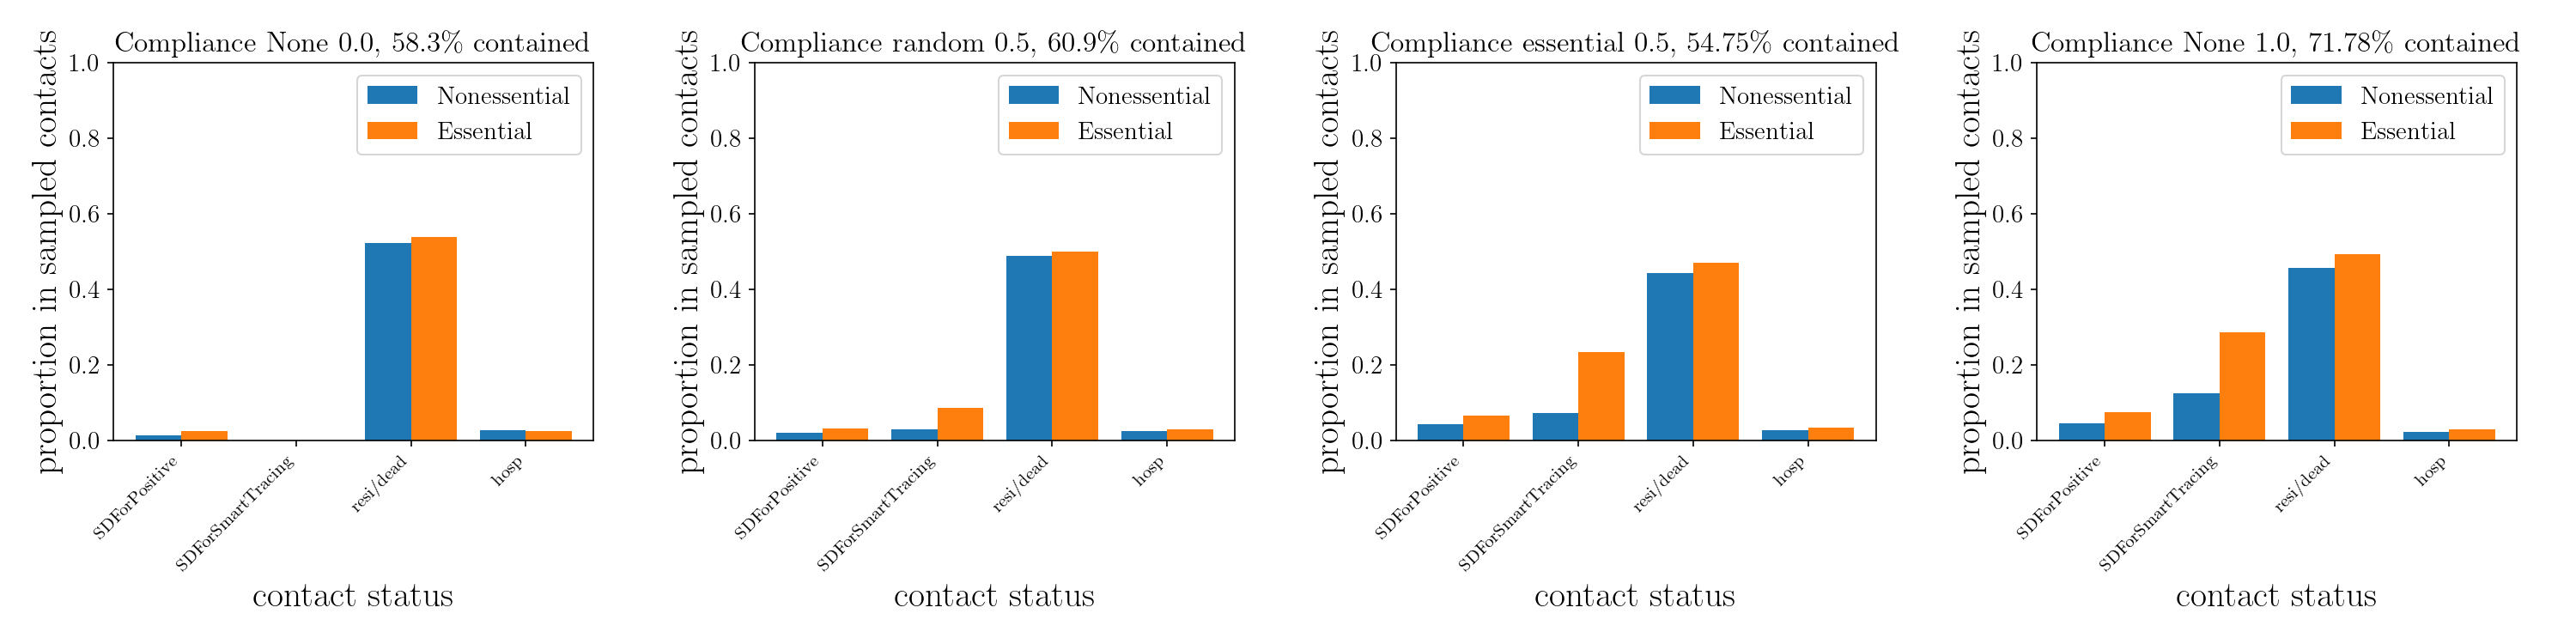

In [12]:
# Plot results of experiments_essential.py
'''
(0) 0: SocialDistancingForAllMeasure`
(1) 1: SocialDistancingForPositiveMeasure
(2) 2: SocialDistancingByAgeMeasure`
(3) 3: SocialDistancingForSmartTracing
(4) 4: SocialDistancingForKGroups`
(5) 5: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
'''
measures = np.array(['SDForAll', 'SDForPositive', 'SDByAge', 'SDForSmartTracing','SDForKGroups','UpperBound','resi/dead','hosp','site_measures','not contained'])

import matplotlib.pyplot as plt
p_compliance = [0.0, 0.5]
measures_deployed = [1,3,6,7]
summaries_ = load_summary('summaries_r54.pk')

f,axs = plt.subplots(1,4,figsize = (20,5))
for j, (policy,p) in enumerate([('None',0.0),('random',0.5),('essential',0.5),('None',1.0)]):
    summary = summaries_[(policy,p)]
    essential_counts = np.zeros((10,))
    essential_num_contacts = 0
    nonessential_counts = np.zeros((10,))
    nonessential_num_contacts = 0
    for r in range(summary.random_repeats):
        for contact in summary.mob[r]:
            if (summary.essential_workers[0][contact.indiv_j]==True):
                essential_num_contacts += 1
                counts = essential_counts
            else:
                nonessential_num_contacts += 1
                counts = nonessential_counts

            if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                counts[9] += 1
            else:
                for i in range(6):
                    if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                        counts[i] += 1
                if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                    counts[6] += 1
                if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                    counts[7] += 1
                if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                    counts[8] += 1

    essential_counts /= essential_num_contacts
    nonessential_counts /= nonessential_num_contacts
    width = 0.4
    xticks = np.arange(1,len(measures_deployed)+1)
    axs[j].bar(xticks-0.2,nonessential_counts[measures_deployed],width=width, label='Nonessential')
    axs[j].bar(xticks+0.2,essential_counts[measures_deployed],width=width, label='Essential')
    axs[j].set_title('Compliance '+policy+' '+str(p)+', '+ str(round((1-counts[9])*100,2))+'\% contained')
    axs[j].set_xlabel('contact status',fontsize = 20)
    axs[j].set_ylabel('proportion in sampled contacts',fontsize = 20)
    axs[j].set_xticks(range(1,len(measures_deployed)+1))
    axs[j].set_xticklabels(measures[measures_deployed],rotation=45,ha='right',fontsize=10)
    axs[j].set_ylim(0,1.0)
    axs[j].legend()
plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()

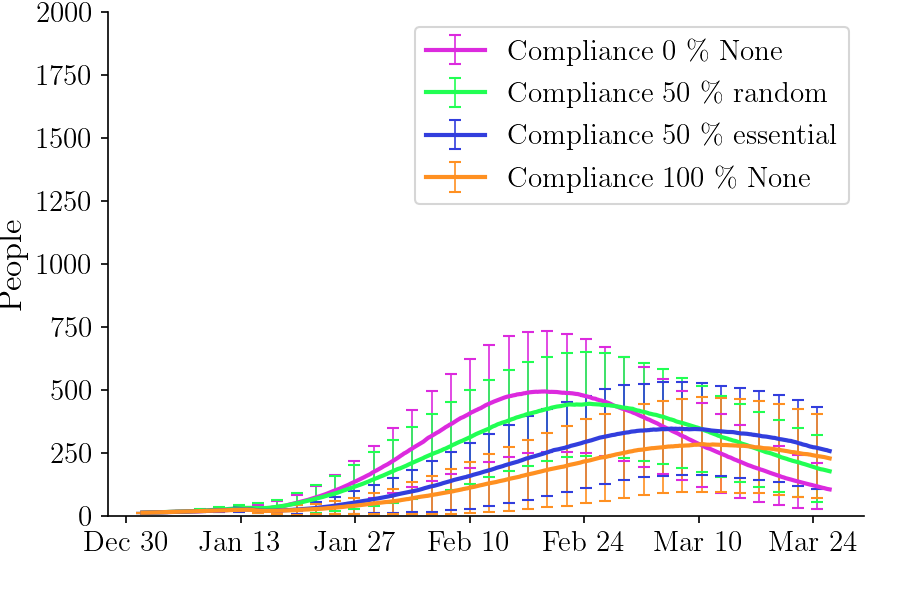

In [8]:
c=0
runstr = f'run{c}_'
# summaries_ = load_summary('contact_record_test_1.pk')
FIGSIZE=(6, 4)

params = [('None',0.0),('random',0.5),('essential',0.5),('None',1.0)]
plotter = Plotter()
titles_ = list(['Compliance '+ str(int(p*100.0)) + ' \%'+' '+policy for (policy, p) in params])
summaries_list = [summaries_[param] for param in params]
plotter.compare_total_infections(
    summaries_list, 
    titles=titles_, 
    filename=runstr + f'experiments_essential', 
    figsize=FIGSIZE, acc=500, 
    ymax=2000, errorevery=14)

In [11]:
for summ in summaries_list:
    df = make_summary_df(summ)
    display(df)

,Total,Nonessential,Essential
num_people,4254,3815,439
num_infected,1820.83,1517.8,303.025
pct_infected,42.8%,39.8%,69.0%
num_contacts,1022.23,323.625,698.6


,Total,Nonessential,Essential
num_people,4254,3815,439
num_infected,1835.5,1517.95,317.55
pct_infected,43.1%,39.8%,72.3%
num_contacts,1035.65,339.425,696.225


,Total,Nonessential,Essential
num_people,4254,3815,439
num_infected,1544,1260.2,283.8
pct_infected,36.3%,33.0%,64.6%
num_contacts,858.75,284.3,574.45


,Total,Nonessential,Essential
num_people,4254,3815,439
num_infected,1277.58,1038.88,238.7
pct_infected,30.0%,27.2%,54.4%
num_contacts,689.425,223.125,466.3


## Emma

In [ ]:
# Plot results of experiments_server_7-1.py
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_r66.pk')
FIGSIZE=(6, 4)

p_compliance = [0.0, 1.0]
plotter = Plotter()
titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' individuals compliant with contact-tracing'),
        filename=runstr + f'SD_6{j}'+'tracing_isolate_5sftest_5trace_sup20_isohouse_40rpts_010betas', 
        figsize=FIGSIZE, acc=500, 
        ymax=5000, errorevery=14)
plt.show()

In [ ]:
c=0
runstr = f'run{c}_'
summaries_SD_6 = load_summary('summaries_r66.pk')
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])

p_compliance = [0.0, 1.0]
all_states = ['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'nega', 'resi', 'dead', 'hosp']
infectious_states = ['ipre', 'isym', 'iasy', 'posi']
noninfectious_states = ['susc', 'expo', 'nega', 'resi', 'dead', 'hosp']
plot_states ='seperate_infectious_noninfectious' #'combine_infectious_states' #['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'resi']

active_measures = ['CT','posi_measure']

alphas = np.linspace(0.6,0.3,num=len(plot_states))
plotter = Plotter()
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
#     f,axs = plt.subplots(1,len(p_compliance),figsize = (13,5))    
    for c, summary in enumerate(summaries_):     # each compliance rate
        fig = plt.figure(figsize=(21,7))
        axs1 = fig.add_subplot(131)
        axs2 = fig.add_subplot(132)
        axs3 = fig.add_subplot(133)
        
        traced_times = {cur_measure: np.zeros(summary.n_people) for cur_measure in active_measures}
        traced_all_states = {cur_state: np.zeros(summary.n_people) for cur_state in all_states}
        traced_all_states_essential = {cur_state: np.zeros(summary.n_people) for cur_state in all_states}
        traced_all_states_normal = {cur_state: np.zeros(summary.n_people) for cur_state in all_states}
        traced_infectious_states = np.zeros(summary.n_people)
        traced_infectious_states_essential = np.zeros(summary.n_people)
        traced_infectious_states_normal = np.zeros(summary.n_people)
        traced_noninfectious_states = np.zeros(summary.n_people)
        traced_noninfectious_states_essential = np.zeros(summary.n_people)
        traced_noninfectious_states_normal = np.zeros(summary.n_people)
        sum_all_states = 0
        sum_all_states_essential = 0
        sum_all_states_normal = 0
        traced_all_states_ratio = {cur_state: np.zeros(1) for cur_state in all_states}
        traced_all_states_ratio_essential = {cur_state: np.zeros(1) for cur_state in all_states}
        traced_all_states_ratio_normal = {cur_state: np.zeros(1) for cur_state in all_states}
        traced_plot_states_ratio = {cur_state: np.zeros(1) for cur_state in plot_states}
        traced_plot_states_ratio_essential = {cur_state: np.zeros(1) for cur_state in plot_states}
        traced_plot_states_ratio_normal = {cur_state: np.zeros(1) for cur_state in plot_states}
        
        for r in range(summary.random_repeats):  # each repeat
            for cur_measure in active_measures:
                traced_times[cur_measure] += summary.is_traced[cur_measure][r]
            for cur_state in all_states:
                traced_all_states[cur_state] += summary.is_traced_state[cur_state][r]            
            
        for cur_measure in active_measures:
            traced_times[cur_measure] /= summary.random_repeats
            
            
        for cur_state in all_states:
            # traced times for all indiv at all states
            traced_all_states[cur_state] /= summary.random_repeats 
            # seperate essential and normal
            traced_all_states_essential[cur_state] = np.multiply(traced_all_states[cur_state],summary.essential_workers[0])
            traced_all_states_normal[cur_state] = np.multiply(traced_all_states[cur_state],1-summary.essential_workers[0])
            
# #             sum_all_states += np.count_nonzero(avg_traced_all_states[cur_state])
# #             traced_all_states_ratio[cur_state] = np.count_nonzero(avg_traced_all_states[cur_state])
# #             sum_all_states_essential += np.count_nonzero(~np.isnan(avg_traced_all_states_essential[cur_state]))
# #             sum_all_states_normal += np.count_nonzero(~np.isnan(avg_traced_all_states_normal[cur_state]))
# #             traced_all_states_ratio_essential[cur_state] = np.count_nonzero(~np.isnan(avg_traced_all_states_essential[cur_state]))
# #             traced_all_states_ratio_normal[cur_state] = np.count_nonzero(~np.isnan(avg_traced_all_states_normal[cur_state]))
            sum_all_states += sum((traced_all_states[cur_state]))
            traced_all_states_ratio[cur_state] = sum((traced_all_states[cur_state])) # to be discussed
            sum_all_states_essential += sum((traced_all_states_essential[cur_state]))
            sum_all_states_normal += sum((traced_all_states_normal[cur_state]))
            traced_all_states_ratio_essential[cur_state] = sum((traced_all_states_essential[cur_state]))
            traced_all_states_ratio_normal[cur_state] = sum((traced_all_states_normal[cur_state]))
       
        for cur_state in all_states:
            if sum_all_states != 0:
                traced_all_states_ratio[cur_state] /= sum_all_states
                traced_all_states_ratio_essential[cur_state] /= sum_all_states_essential
                traced_all_states_ratio_normal[cur_state] /= sum_all_states_normal
            else:
                traced_all_states_ratio[cur_state] = 0
                traced_all_states_ratio_essential[cur_state] = 0
                traced_all_states_ratio_normal[cur_state] = 0
         
        
        for cur_state in infectious_states:
            traced_infectious_states += traced_all_states[cur_state]
            traced_infectious_states_essential = np.multiply(traced_infectious_states,summary.essential_workers[0])
            traced_infectious_states_normal = np.multiply(traced_infectious_states,1-summary.essential_workers[0])
            traced_infectious_states_essential[traced_infectious_states_essential==0] = 'nan'
            traced_infectious_states_normal[traced_infectious_states_normal==0] = 'nan'
        for cur_state in noninfectious_states:
            traced_noninfectious_states += traced_all_states[cur_state]
            traced_noninfectious_states_essential = np.multiply(traced_noninfectious_states,summary.essential_workers[0])
            traced_noninfectious_states_normal = np.multiply(traced_noninfectious_states,1-summary.essential_workers[0])
            traced_noninfectious_states_essential[traced_noninfectious_states_essential==0] = 'nan'
            traced_noninfectious_states_normal[traced_noninfectious_states_normal==0] = 'nan'
            
        
        
        ## plot
        axs1.plot(traced_times['CT'],traced_times['CT'],linestyle='--',color='black',alpha=0.1)
        axs2.plot(traced_times['CT'],traced_times['CT'],linestyle='--',color='black',alpha=0.1)
        axs3.plot(traced_times['CT'],traced_times['CT'],linestyle='--',color='black',alpha=0.1)
        if plot_states == 'combine_infectious_states':
            axs1.scatter(traced_times, traced_infectious_states_essential, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:blue')
            axs1.scatter(traced_times, traced_infectious_states_essential, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:red')            
            axs2.scatter(traced_times, traced_infectious_states_essential, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:red')
            axs3.scatter(traced_times, traced_infectious_states_normal, 
                               alpha=alphas[i], edgecolors=None, label=cur_state, color='tab:blue')
            axs1.set_title('infectious traced freq for all indiv')
            axs2.set_title('infectious traced freq for essential')
            axs3.set_title('infectious traced freq for non essential')
        elif plot_states == 'nonzero_states':
            for i, cur_state in enumerate(all_states):
                if sum(traced_all_states[cur_state]) != 0:
                    axs.scatter(traced_times, traced_all_states[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state)
                    axs.legend()
        elif plot_states == 'seperate_infectious_noninfectious':
            alll = np.nansum(traced_noninfectious_states) + np.nansum(traced_infectious_states)
            axs1.scatter(traced_times['CT'], traced_noninfectious_states, 
                               alpha=0.6, edgecolors=None, label='non-infectious: '
                         +str(round((np.nansum(traced_noninfectious_states)/alll)*100,2))+'\%', color='tab:blue')
            axs1.scatter(traced_times['CT'], traced_infectious_states, 
                               alpha=0.3, edgecolors=None, label='infectious: '
                         +str(round((np.nansum(traced_infectious_states)/alll)*100,2))+'\%', color='tab:red')  
            alll = np.nansum(traced_noninfectious_states_essential) + np.nansum(traced_infectious_states_essential)
            axs2.scatter(traced_times['CT'], traced_noninfectious_states_essential, 
                               alpha=0.6, edgecolors=None, label='non-infectious: '
                         +str(round((np.nansum(traced_noninfectious_states_essential)/alll)*100,2))+'\%', color='tab:blue')
            axs2.scatter(traced_times['CT'], traced_infectious_states_essential, 
                               alpha=0.3, edgecolors=None, label='infectious: '
                         +str(round((np.nansum(traced_infectious_states_essential)/alll)*100,2))+'\%', color='tab:red')
            alll = np.nansum(traced_noninfectious_states_normal) + np.nansum(traced_infectious_states_normal)
            axs3.scatter(traced_times['CT'], traced_noninfectious_states_normal,
                               alpha=0.6, edgecolors=None, label='non-infectious: '
                         +str(round((np.nansum(traced_noninfectious_states_normal)/alll)*100,2))+'\%', color='tab:blue')
            axs3.scatter(traced_times['CT'], traced_infectious_states_normal, 
                               alpha=0.3, edgecolors=None, label='infectious: '
                         +str(round((np.nansum(traced_infectious_states_normal)/alll)*100,2))+'\%', color='tab:red')
            
        else:
            # compute relative state ratio
            sum_traced_plot_states_ratio = 0
            sum_traced_plot_states_ratio_essential = 0
            sum_traced_plot_states_ratio_normal = 0
            for cur_state in plot_states:
                sum_traced_plot_states_ratio += traced_all_states_ratio[cur_state]
                traced_plot_states_ratio[cur_state] = traced_all_states_ratio[cur_state]
                sum_traced_plot_states_ratio_essential += traced_all_states_ratio_essential[cur_state]
                traced_plot_states_ratio_essential[cur_state] = traced_all_states_ratio_essential[cur_state]
                sum_traced_plot_states_ratio_normal += traced_all_states_ratio_normal[cur_state]
                traced_plot_states_ratio_normal[cur_state] = traced_all_states_ratio_normal[cur_state]
            for cur_state in plot_states:
                traced_all_states_essential[cur_state][traced_all_states_essential[cur_state]==0] = 'nan'
                traced_all_states_normal[cur_state][traced_all_states_normal[cur_state]==0] = 'nan'
                if sum_traced_plot_states_ratio != 0:
                    traced_plot_states_ratio[cur_state] /= sum_traced_plot_states_ratio
                    traced_plot_states_ratio_essential[cur_state] /= sum_traced_plot_states_ratio_essential
                    traced_plot_states_ratio_normal[cur_state] /= sum_traced_plot_states_ratio_normal
            # plot            
            for i, cur_state in enumerate(plot_states):
                axs1.scatter(traced_times, traced_all_states[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state+': '
                             +str(round(traced_plot_states_ratio[cur_state]*100,2))+'\%')
                axs2.scatter(traced_times, traced_all_states_essential[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state+': '
                             +str(round(traced_plot_states_ratio_essential[cur_state]*100,2))+'\%')
                axs3.scatter(traced_times, traced_all_states_normal[cur_state], 
                               alpha=alphas[i], edgecolors=None, label=cur_state+': '
                             +str(round(traced_plot_states_ratio_normal[cur_state]*100,2))+'\%')
                
                
        
#         axs1.set_title('Stay home by Posi measure vs by CT for ' + r"$\bf{" + 'all\ indiv' + "}$")
#         axs2.set_title('Stay home by Posi measure vs by CT for ' + r"$\bf{" + 'essential' + "}$")
#         axs3.set_title('Stay home by Posi measure vs by CT for ' + r"$\bf{" + 'non-essential' + "}$")
        axs1.set_title('Infectious vs non-infectious stay home for ' + r"$\bf{" + 'all\ indiv' + "}$")
        axs2.set_title('Infectious vs non-infectious stay home for ' + r"$\bf{" + 'essential' + "}$")
        axs3.set_title('Infectious vs non-infectious stay home for ' + r"$\bf{" + 'non-essential' + "}$")
        axs1.legend()
        axs2.legend()
        axs3.legend()
        axs1.set_xticks(range(0, int(max(traced_times['CT'])+1)))
        axs2.set_xticks(range(0, int(max(traced_times['CT'])+1)))
        axs3.set_xticks(range(0, int(max(traced_times['CT'])+1)))
        axs1.set_xlabel('traced frequency, [num of times]',fontsize = 15)
        axs2.set_xlabel('traced frequency, [num of times]',fontsize = 15)
        axs3.set_xlabel('traced frequency, [num of times]',fontsize = 15)
        axs1.set_ylabel('traced state frequency, [num of times]',fontsize = 15)
#         axs2.set_ylabel('traced state frequency, [num of times]',fontsize = 15)
#         axs3.set_ylabel('traced state frequency, [num of times]',fontsize = 15)
            
        print(traced_times)
#         print(avg_traced_infectious_states)
#         print(traced_all_states_ratio)

        
        
plt.show()

In [ ]:
def computeAverageTraced(summary,cur_state,r,t):
    cur_num_of_traced_indiv = 0
    repeatr_trace_started_at = summary.trace_started_at[cur_state][r]
    repeatr_trace_ended_at = summary.trace_ended_at[cur_state][r]
    for i in range(summary.n_people):   # each person
        if repeatr_trace_started_at[i]: # if person i is traced
            for cur_traced_time in range(len(repeatr_trace_started_at[i])):
                if (repeatr_trace_started_at[i][cur_traced_time]<t) and (repeatr_trace_ended_at[i][cur_traced_time])>t: # if i is home at t
                    if (cur_traced_time ==0):
                        cur_num_of_traced_indiv += 1
                    if (cur_traced_time != 0) and (repeatr_trace_started_at[i][cur_traced_time] > 
                                                   (repeatr_trace_started_at[i][cur_traced_time-1]+24.0*7)):
                        cur_num_of_traced_indiv += 1
    return cur_num_of_traced_indiv




c=0
runstr = f'run{c}_'
TO_HOURS = 24.0
acc=500
summaries_SD_6 = load_summary('summaries_SD_5.pk')
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance])

p_compliance = [0.0, 1.0]
all_states = ['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'nega', 'resi', 'dead', 'hosp']
infectious_states = ['ipre', 'isym', 'iasy', 'posi']
plot_states = infectious_states #'combine_infectious_states' #['susc', 'expo', 'ipre', 'isym', 'iasy', 'posi', 'resi']
alphas = np.linspace(0.6,0.3,num=len(plot_states))

plotter = Plotter()
for j, policy in enumerate(['basic','advanced']):
    summaries_ = summaries_SD_6[policy]
#     f,axs = plt.subplots(1,len(p_compliance),figsize = (13,5))    
    for c, summary in enumerate(summaries_):     # each compliance rate
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)      
        
        ts_ipre, means_ipre, stds_ipre = [], [], []
        ts_isym, means_isym, stds_isym = [], [], []
        ts_iasy, means_iasy, stds_iasy = [], [], []
        ts_posi, means_posi, stds_posi = [], [], []
        ts_CT, means_CT, stds_CT = [], [], []
        cur_num_of_ipre_traced_indiv = np.zeros(summary.random_repeats)
        cur_num_of_isym_traced_indiv = np.zeros(summary.random_repeats)
        cur_num_of_iasy_traced_indiv = np.zeros(summary.random_repeats)
        cur_num_of_posi_traced_indiv = np.zeros(summary.random_repeats)
            
        for t in np.linspace(0.0, summary.max_time, num=acc, endpoint=True): # each time
            for r in range(summary.random_repeats):  # each repeat
                cur_num_of_ipre_traced_indiv[r] = computeAverageTraced(summary,'ipre',r,t)
                cur_num_of_isym_traced_indiv[r] = computeAverageTraced(summary,'isym',r,t)
                cur_num_of_iasy_traced_indiv[r] = computeAverageTraced(summary,'iasy',r,t)
                cur_num_of_posi_traced_indiv[r] = computeAverageTraced(summary,'posi',r,t)
                    
                    
#                 repeatr_ipre_trace_started_at = summary.trace_started_at['ipre'][r]
#                 repeatr_ipre_trace_ended_at = summary.trace_ended_at['ipre'][r]
#                 for i in range(summary.n_people):   # each person
#                     if repeatr_ipre_trace_started_at[i]: # if person i is traced
                        
#                         for cur_traced_time in range(len(repeatr_ipre_trace_started_at[i])):
#                             if (repeatr_ipre_trace_started_at[i][cur_traced_time]<t) and (repeatr_CT_trace_ended_at[i][cur_traced_time])>t: # if i is home at t
#                                 if (cur_traced_time ==0):
#                                     cur_num_of_ipre_traced_indiv[r] += 1
#                                 if (cur_traced_time != 0) and (repeatr_ipre_trace_started_at[i][cur_traced_time] > 
#                                 (repeatr_ipre_trace_started_at[i][cur_traced_time-1]+24.0*7)):
#                                     cur_num_of_ipre_traced_indiv[r] += 1

                                                    
#                         cur_num_of_CT_traced_indiv[r] += 
#                         np.sum([(repeatr_CT_trace_started_at[i][j]<t) and (repeatr_CT_trace_ended_at[i][j])>t 
#                                 for j in range(len(repeatr_CT_trace_ended_at[i]))])

            cur_num_of_CT_traced_indiv = cur_num_of_ipre_traced_indiv+cur_num_of_isym_traced_indiv+cur_num_of_iasy_traced_indiv
            ts_CT.append(t/TO_HOURS)
            means_CT.append(np.mean(cur_num_of_CT_traced_indiv))
            stds_CT.append(np.std(cur_num_of_CT_traced_indiv))
            ts_ipre.append(t/TO_HOURS)
            means_ipre.append(np.mean(cur_num_of_ipre_traced_indiv))
            stds_ipre.append(np.std(cur_num_of_ipre_traced_indiv))
            ts_isym.append(t/TO_HOURS)
            means_isym.append(np.mean(cur_num_of_isym_traced_indiv))
            stds_isym.append(np.std(cur_num_of_isym_traced_indiv))
            ts_iasy.append(t/TO_HOURS)
            means_iasy.append(np.mean(cur_num_of_iasy_traced_indiv))
            stds_iasy.append(np.std(cur_num_of_iasy_traced_indiv))
            ts_posi.append(t/TO_HOURS)
            means_posi.append(np.mean(cur_num_of_posi_traced_indiv))
            stds_posi.append(np.std(cur_num_of_posi_traced_indiv))
            
            # ax.errorbar(ts_CT, means_CT, yerr=stds_CT)
            ax.plot(ts_CT,means_CT,label='CT')
            ax.plot(ts_posi,means_posi,label='posi measure')
            ax.set_xlabel('simulation time, [days]',fontsize = 15)
            ax.set_ylabel('infectious population stay home',fontsize = 15)
            ax.set_title('CT=1.0, '+ policy)
            ax.legend()
                    
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# ax.errorbar(ts_CT, means_CT, yerr=stds_CT)
ax.plot(ts_CT,means_CT,label='CT')
ax.plot(ts_posi,means_posi,label='posi measure')
ax.set_xlabel('simulation time, [days]',fontsize = 15)
ax.set_ylabel('infectious population stay home',fontsize = 15)
ax.set_title('CT=1.0, advanced')
ax.legend()
plt.show()


In [ ]:
'''
(0) 1: SocialDistancingForAllMeasure`
(1) 2: SocialDistancingForPositiveMeasure
(2) 3: SocialDistancingByAgeMeasure`
(3) 4: SocialDistancingForSmartTracing
(4) 5: SocialDistancingForKGroups`
(5) 6: UpperBoundCasesSocialDistancing`
(6) 'resi/dead'
(7) 'hosp'
(8) 'site_measures'
(9) not contained
(10) contained_infectious
'''
import matplotlib.pyplot as plt
rpts = 2
p_compliance = [0.0, 1.0]
measures_deployed = [0,1,3,6,7]
measures_deployed_str = ['Shutdown','Posi Measure',
                         'Age Measure','CT',
                         'K groups','Upper Bound','resi/dead','hosp']
# summaries_SD_6 = load_summary('summaries_SD_5_advanced.pk')
summaries_SD_6 = load_summary('summaries_r62.pk')
for j, policy in enumerate(['advanced']):
    summaries_ = summaries_SD_6[policy]
    f,axs = plt.subplots(1,2,figsize = (13,5))
    f1,axs1 = plt.subplots(1,2,figsize = (13,5))
    f2,axs2 = plt.subplots(1,2,figsize = (13,5))
    for s, summary in enumerate(summaries_):
        counts = np.zeros((11,))
        num_contacts = 0
        for r in range(rpts):
            num_contacts += len(summary.mob[r])
            for contact in summary.mob[r]:                
                if (not contact.data['i_contained']) and (not contact.data['j_contained'] ):
                    counts[9] += 1
                else:
                    for i in range(6):
                        if (i in contact.data['i_contained_by']) or (i in contact.data['j_contained_by']):
                            counts[i] += 1
                    if ('resi/dead' in contact.data['i_contained_by']) or ('resi/dead' in contact.data['j_contained_by']):
                        counts[6] += 1
                    if ('hosp' in contact.data['i_contained_by']) or ('hosp' in contact.data['j_contained_by']):
                        counts[7] += 1
                    if ('site_measures' in contact.data['i_contained_by']) or ('site_measures' in contact.data['j_contained_by']):
                        counts[8] += 1
                if contact.data['i_contained_infectious'] or contact.data['j_contained_infectious']:
                    counts[10] += 1
                    
        counts /= num_contacts
        counts[10] = counts[10]/sum(counts[0:5])
        measure_distribution = counts[0:8]/sum(counts[0:8])
        print('infectious contained rate: ', counts[10])
        axs[s].bar(range(1,len(measures_deployed)+1),counts[measures_deployed])
        axs[s].set_title('CT '+str(p_compliance[s])+', '+ str(round((1-counts[9])*100,2))+'\% contained, '+str(round(counts[10]*100,2))+'\% are infectious')
        axs[s].set_xlabel('contact status',fontsize = 20)
        axs[s].set_ylabel('proportion in sampled contacts',fontsize = 20)
        axs[s].set_xticks(range(1,len(measures_deployed)+1))
        axs[s].set_xticklabels(measures_deployed)
        axs[s].set_ylim(0,0.8)
        
#         axs1[s].pie(measure_distribution,labels=measures_deployed_str)
        text = axs1[s].pie(measure_distribution,labels=measures_deployed_str,autopct='%.2f')[1]
        fixOverLappingText(text)
#         for label, t in zip(measures_deployed_str, text[1]):
#             x, y = t.get_position()
#             angle = int(math.degrees(math.atan2(y, x)))
#             ha = "left"
#             va = "bottom"

#             if angle > 90:
#                 angle -= 180

#             if angle < 0:
#                 va = "top"

#             if -45 <= angle <= 0:
#                 ha = "right"
#                 va = "bottom"

#             plt.annotate(label, xy=(x,y), rotation=angle, ha=ha, va=va, size=8)

        
        
#plt.tight_layout()
#plt.savefig('plots/contact_details.png',dpi=300)
plt.show()



